In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pymc3 as pm
import ptitprince as pt
import arviz as az
az.style.use('arviz-darkgrid')

C:\Users\Mikko\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Mikko\AppData\Local\Continuum\anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Chapter 5 exercises

### 5E1

$$ \mu_i = \beta_x x_i + \beta_z z_i $$
$$ \mu_i = \alpha + \beta (x_i - z_i) $$
$$ \mu_i = \alpha + \beta_x x_i + \beta_z z_i $$

### 5E2

$$ \mu_i = \alpha + \beta_A A_i + \beta_P P_i $$

where $A_i$ is animal diversity and $ P_i $ is plant diversity

### 5E3

$$ \mu_i = \alpha + \beta_S S_i + \beta_F F_i $$

where $ S_i $ is size and $ F_i $ is funding

Let's attempt to produce a dataset with similar properties as given in the assignment

In [8]:
N = 1000
rho = 0.8
x = stats.norm.rvs(loc=10, scale = 1, size = N)
y = stats.norm.rvs(loc = -rho * x, scale = np.sqrt(1-rho**2), size = N)
z = stats.norm.rvs(loc = x+y, scale = 0.5, size = N)

In [12]:
df = pd.DataFrame([x,y,z]).T

In [14]:
df.columns = ['x','y','z']

In [15]:
df.head()

,x,y,z
0,11.140994,-8.966381,2.571515
1,10.993510,-8.561723,2.119456
2,11.094902,-8.022258,3.952021
3,10.465119,-7.183165,3.617219
4,9.144824,-6.372711,3.052179


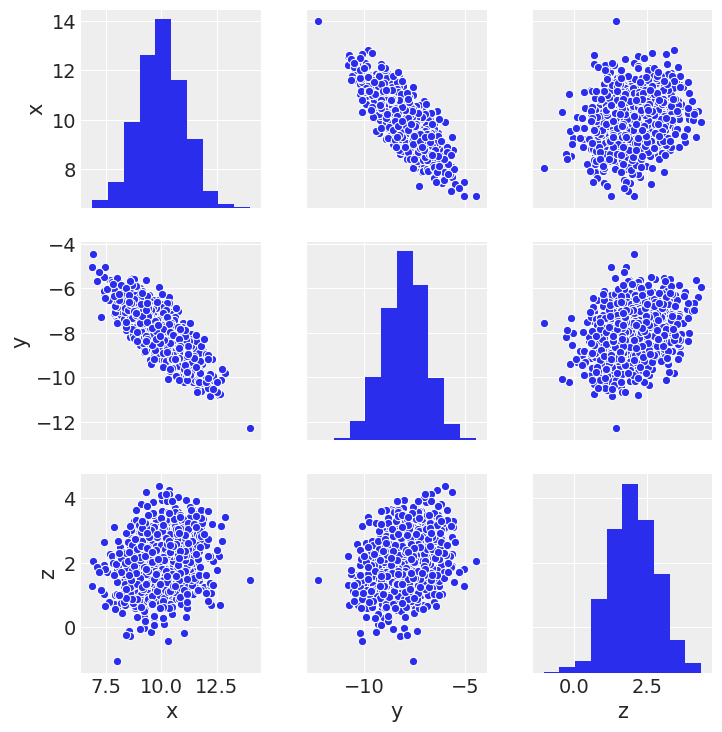

In [28]:
sns.pairplot(df)

In [47]:
with  pm.Model() as m5e3x:
    sigma = pm.Uniform('sigma',lower=0,upper =10)
    alpha = pm.Normal('alpha',0,1)
    beta_x = pm.Normal('beta_x', 0,1)
    mu = pm.Deterministic('mu', alpha + beta_x * df['x'])
    z = pm.Normal('z', mu, sigma, observed = df['z'])
    t5e3x = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_x, alpha, sigma]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 8000/8000 [00:10<00:00, 737.98draws/s]


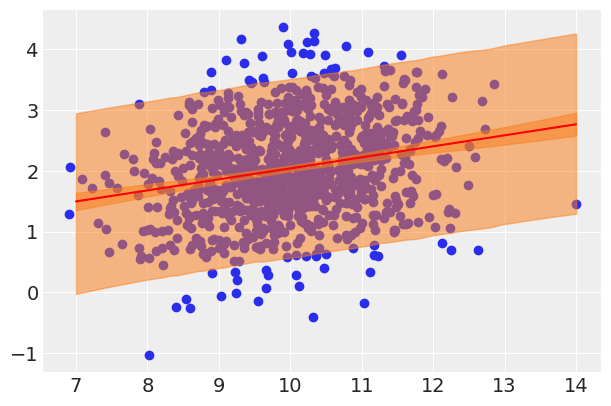

In [43]:
x_points = np.linspace(7,14,100)
plt.scatter(df['x'], df['z'])
mu_pred = (t5e3x['alpha'] + t5e3x['beta_x']* x_points[:,None])
predicted = stats.norm.rvs(mu_pred, scale = t5e3x['sigma'])

plt.plot(x_points, t5e3x['alpha'].mean() + t5e3x['beta_x'].mean()* x_points[:,None], color = 'red')
az.plot_hpd(x_points, mu_pred.T)
az.plot_hpd(x_points, predicted.T)

In [73]:
with pm.Model() as m5e3y:
    sigma = pm.Uniform('sigma',lower=0,upper =10)
    alpha = pm.Normal('alpha',0,1)
    beta_y = pm.Normal('beta_y', 0,1)
    mu = pm.Deterministic('mu', alpha + beta_y * df['y'])
    z = pm.Normal('z', mu, sigma, observed = df['z'])
    t5e3y = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_y, alpha, sigma]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 8000/8000 [00:12<00:00, 654.50draws/s]


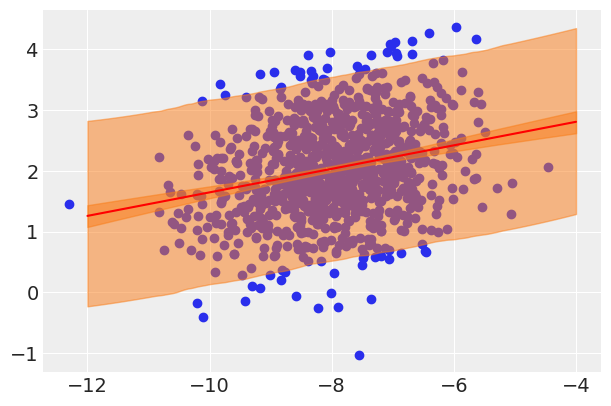

In [59]:
plt.scatter(df['y'], df['z'])
x_points = np.linspace(-12,-4,100)
plt.plot(x_points, t5e3y['alpha'].mean() + t5e3y['beta_y'].mean() * x_points[:,None], color = 'red')
mu_pred = t5e3y['alpha'] + t5e3y['beta_y'] * x_points[:,None]
predicted = stats.norm.rvs(mu_pred, t5e3y['sigma'])
az.plot_hpd(x_points, mu_pred.T)
az.plot_hpd(x_points, predicted.T, credible_interval= 0.95)

In [61]:
with pm.Model() as m5e3xy:
    sigma = pm.Uniform('sigma',lower=0,upper =10)
    alpha = pm.Normal('alpha',0,1)
    beta_y = pm.Normal('beta_y', 0,1)
    beta_x = pm.Normal('beta_x', 0,1)
    mu = pm.Deterministic('mu', alpha + beta_x * df['x'] + beta_y * df['y'])
    z = pm.Normal('z', mu, sigma, observed = df['z'])
    t5e3xy = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_x, beta_y, alpha, sigma]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 8000/8000 [00:22<00:00, 352.84draws/s]


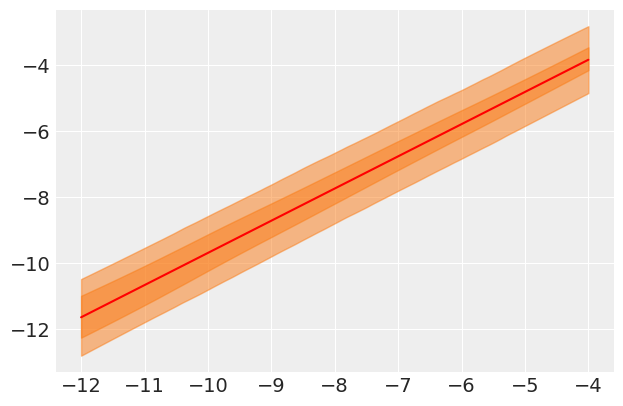

In [72]:
x_points = np.linspace(-12,-4,100)
plt.plot(x_points, t5e3xy['alpha'].mean() + t5e3xy['beta_y'].mean() * x_points[:,None] , color = 'red')
mu_pred = t5e3xy['alpha'] + t5e3xy['beta_y'] * x_points[:,None]
predicted = stats.norm.rvs(mu_pred, t5e3xy['sigma'])
az.plot_hpd(x_points, mu_pred.T)
az.plot_hpd(x_points, predicted.T, credible_interval= 0.95)

GridSpec(1, 2, width_ratios=[3, 1])

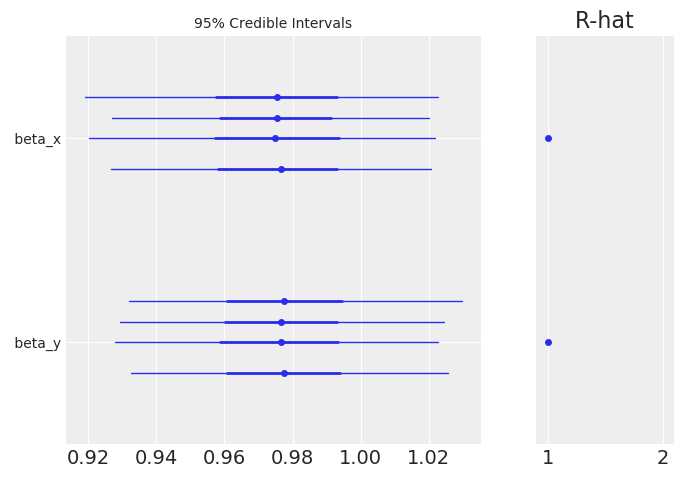

In [74]:
pm.forestplot(t5e3xy, varnames=['beta_x', 'beta_y'])

GridSpec(1, 2, width_ratios=[3, 1])

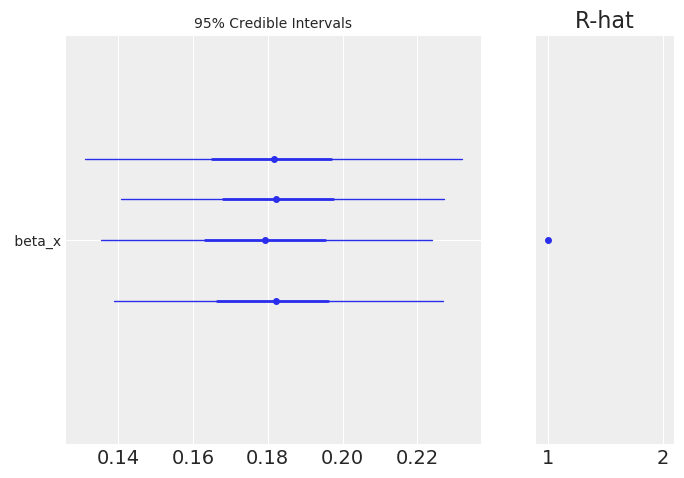

In [75]:
pm.forestplot(t5e3x, varnames=['beta_x'])

GridSpec(1, 2, width_ratios=[3, 1])

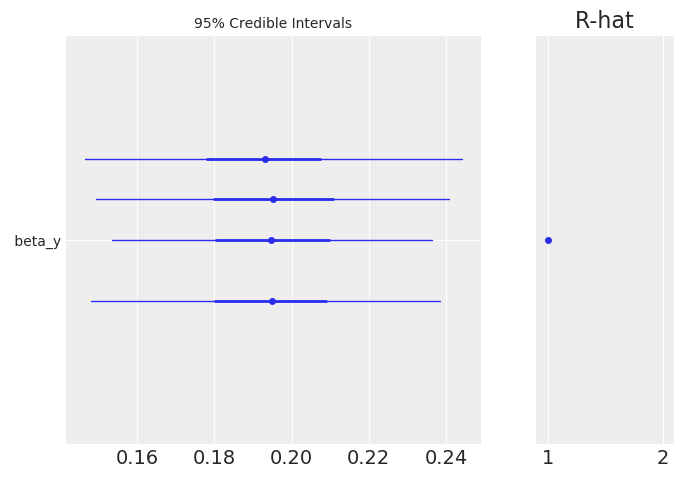

In [76]:
pm.forestplot(t5e3y, varnames=['beta_y'])

It appears that predictors can be weak in individual linear regression, if they are themselves negatively correlated with one another. By using multiple linear regression, we can unmask this relationship, and reveal that both predictors are strong predictors together

### 5M1

In [106]:
x = stats.norm.rvs(0,1,1000)
y = stats.norm.rvs(x, 1, 1000)
z = stats.norm.rvs(0.8* x, 1, 1000)

In [107]:
df = pd.DataFrame([x,y,z]).T

In [110]:
df.columns = ('x', 'y','z')

In [111]:
df.head()

,x,y,z
0,0.375928,-0.288978,0.746773
1,-0.464455,-0.609690,0.337084
2,-0.791814,1.298481,-1.602861
3,0.252178,-0.851632,-0.965368
4,-1.954157,-0.313561,0.062247


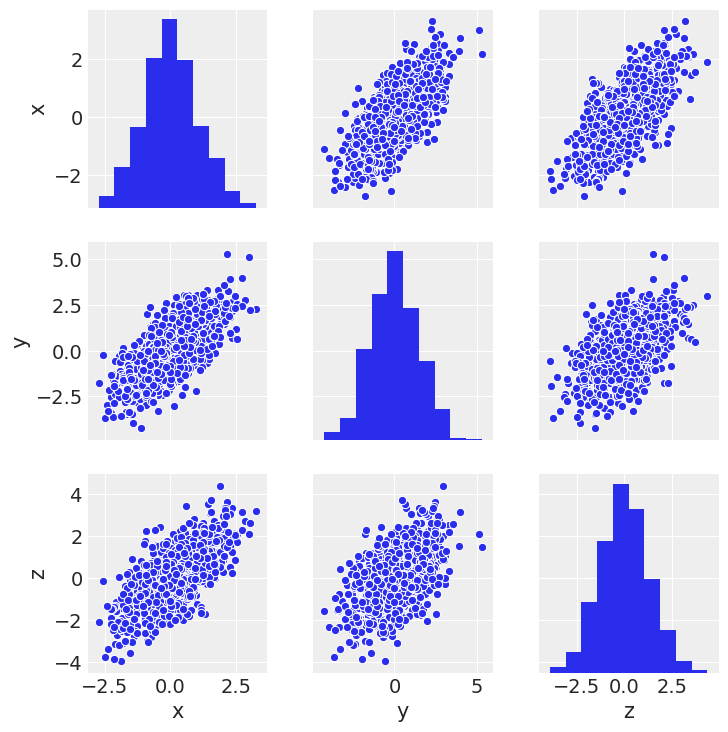

In [112]:
sns.pairplot(df)

In [113]:
with pm.Model() as m51:
    sigma = pm.Exponential('sigma',1)
    beta_x = pm.Normal('beta_x',0,0.2)
    beta_y = pm.Normal('beta_y',0,0.2)
    alpha = pm.Normal('alpha', 0,0.2)
    mu = pm.Deterministic('mu', alpha + beta_x * df['x'] + beta_y * df['y'])
    predicted = pm.Normal('predicted', mu, sigma, observed = df['z'])
    trace = pm.sample(1000, tune= 1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_y, beta_x, sigma]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 8000/8000 [00:08<00:00, 916.62draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028FADF9C128>,
      dtype=object)

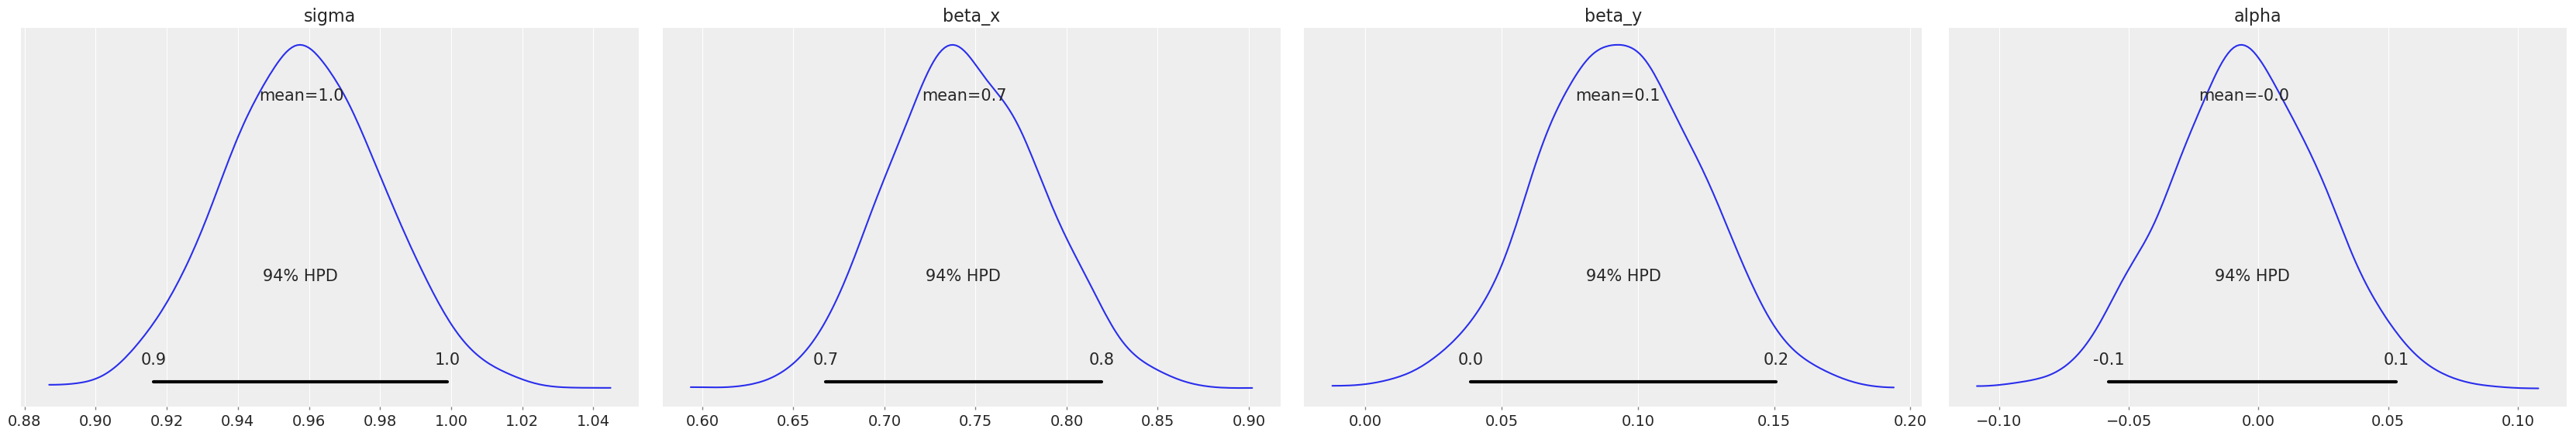

In [120]:
az.plot_posterior(trace, var_names=['sigma', 'beta_x', 'beta_y', 'alpha'])

In [119]:
pm.summary(trace, varnames = ['sigma', 'beta_x', 'beta_y', 'alpha'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,0.957959,0.022129,0.000345,0.914552,1.000656,3749.266230,0.999874
beta_x,0.743941,0.041499,0.000727,0.666084,0.824781,3219.700623,0.999817
beta_y,0.092597,0.029929,0.000497,0.034226,0.151440,3261.354868,0.999886
alpha,-0.005547,0.029793,0.000421,-0.064797,0.050526,4055.891238,0.999771


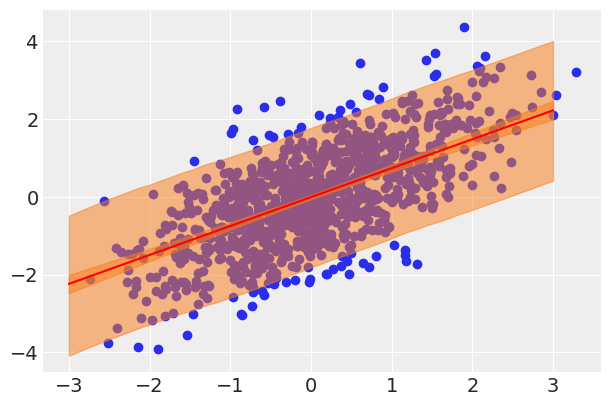

In [131]:
plt.scatter(df['x'], df['z'])
x_steps = np.linspace(-3,3,100)
mu_mean = trace.alpha.mean() + trace.beta_x.mean() * x_steps[:,None]
plt.plot(x_steps, mu_mean, 'red')
mu_pred = trace.alpha + trace.beta_x * x_steps[:,None]
az.plot_hpd(x_steps, mu_pred.T)
predicted = stats.norm.rvs(mu_pred, trace.sigma)
az.plot_hpd(x_steps, predicted.T)

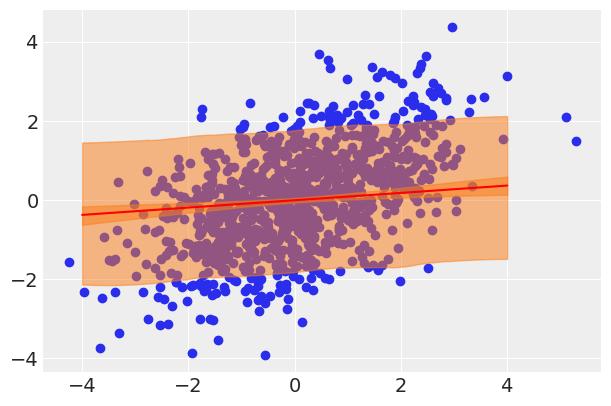

In [133]:
plt.scatter(df['y'], df['z'])
x_steps = np.linspace(-4,4,100)
mu_mean = trace.alpha.mean() + trace.beta_y.mean() * x_steps[:,None]
plt.plot(x_steps, mu_mean, 'red')
mu_pred = trace.alpha + trace.beta_y * x_steps[:,None]
az.plot_hpd(x_steps, mu_pred.T)
predicted = stats.norm.rvs(mu_pred, trace.sigma)
az.plot_hpd(x_steps, predicted.T)

We can generate a spurious correlaction by creating a distribution 'y' which correlates strongly with 'x'. The distribution 'z', which is strongly correlated with x, appears to have a strong correlation with 'y' in the pairplot, even though no such correlation exists. Multiple regression reveals this spurious correlation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028FAC197D68>,
      dtype=object)

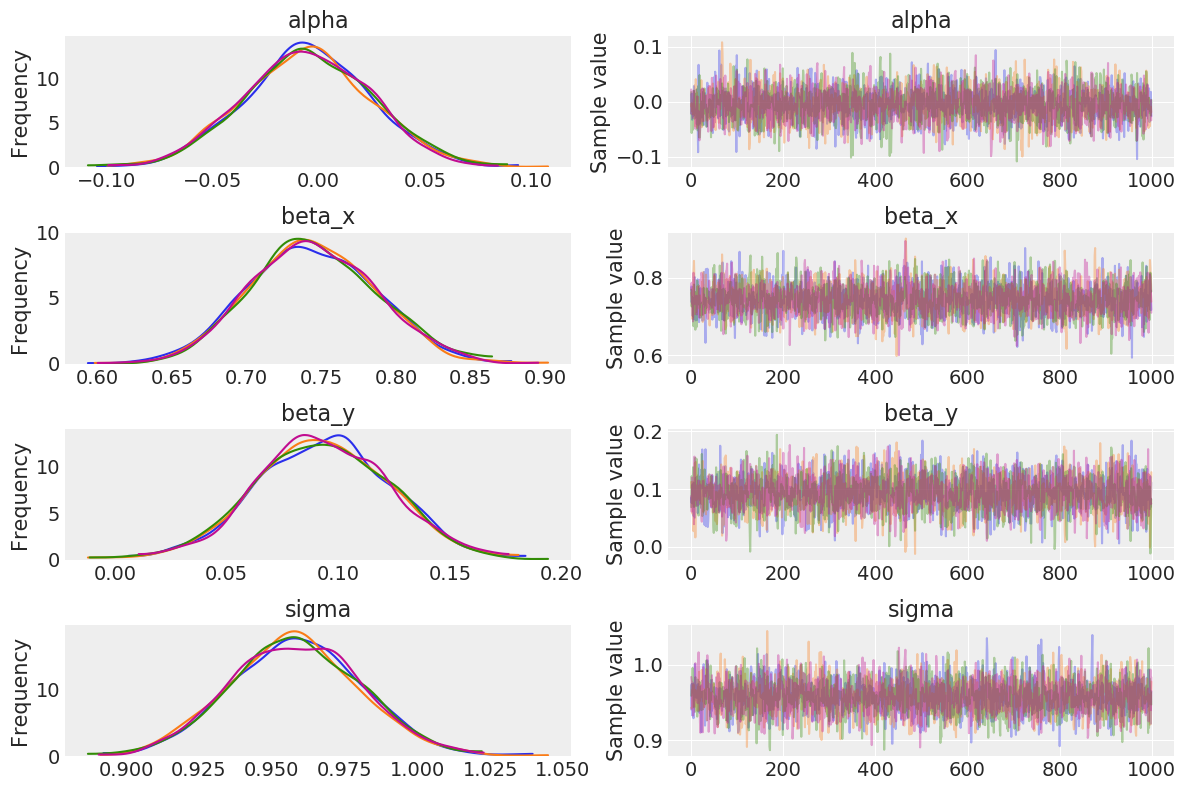

In [136]:
pm.traceplot(trace, varnames = ['alpha', 'beta_x', 'beta_y', 'sigma'])

### 5M2. Masked relationship

In [172]:
x = stats.norm.rvs(0,1,1000)
y = stats.norm.rvs(- x, 0.5,1000)
z = stats.norm.rvs(x+y,1,1000)

In [173]:
df = pd.DataFrame([x,y,z]).T

In [174]:
df.columns = ['x', 'y', 'z']

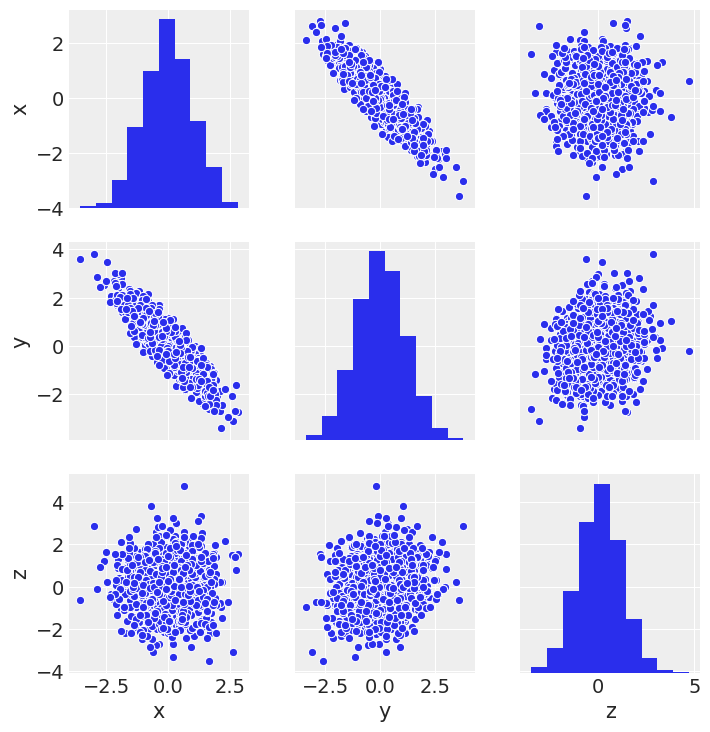

In [175]:
sns.pairplot(df)

### 5M3

Higher divorce rates may cause higher marriage rates , if people re-marry. To evaluate this relationship, we can regress marriage rate on divorce rate and re-marriage rate. If the divorce rate has negligible correlation with marriage rate after controlling for re-marriage rate, we can argue that the correlation between divorce rate and higher marriage rate is caused by increases in re-marriage.

### 5M4

In [284]:
dfs = pd.read_html('https://www.worldatlas.com/articles/mormon-population-by-state.html')

In [285]:
df_lds = dfs[0]

In [286]:
df = pd.read_csv('../resources/Rethinking/Data/WaffleDivorce.csv', sep =';')

In [287]:
df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [288]:
df_lds.head()

,Rank,﻿State,Estimated Mormon Population,Total State Population,Percentage of Mormon Residents
0,1,Utah,2065808,3051217,67.70%
1,2,Idaho,444614,1683140,26.42%
2,3,Wyoming,67505,585501,11.53%
3,4,Nevada,182617,2940058,6.21%
4,5,Arizona,423056,6931071,6.10%


In [289]:
df_lds.columns= ['Rank', 'Location', 'Estimated Mormon Population', 'Total State Population', 'Percentage of Mormon Residents']

In [291]:
df_ready = df.join(df_lds.set_index('Location'), on='Location')

Convert mormon percentage to log scale to enforce positive values

In [297]:
df_ready['log mormon percentage'] = np.log(df_ready['Percentage of Mormon Residents'].str.rstrip('%').astype(float))

Standardize mormon percentage

In [301]:
df_ready['mormon percentage SE'] = (df_ready['log mormon percentage'] - df_ready['log mormon percentage'].mean())/df_ready['log mormon percentage'].std()

In [304]:
df_ready['MedianAgeMarriage SE'] = (df_ready['MedianAgeMarriage'] - df_ready['MedianAgeMarriage'].mean())/df_ready['MedianAgeMarriage'].std()

In [307]:
df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,Rank,Estimated Mormon Population,Total State Population,Percentage of Mormon Residents,log mormon percentage,mormon percentage SE,MedianAgeMarriage SE
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,30,37237,4863300,0.77%,-0.261365,-0.399014,-0.606290
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,8,33810,741894,4.56%,1.517323,1.200236,-0.686699
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,5,423056,6931071,6.10%,1.808289,1.461848,-0.204241
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,22,30694,2988248,1.03%,0.029559,-0.137439,-1.410387
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,13,771464,39250017,1.97%,0.678034,0.445616,0.599857


In [309]:
with pm.Model() as M53:
    sigma = pm.Uniform('sigma',0,0.5)
    alpha = pm.Normal('alpha',0,0.2)
    beta_mr = pm.Normal('beta_mr',0,0.2)
    beta_ma = pm.Normal('beta_ma',0,0.2)
    beta_mor = pm.Normal('beta_mor',0, 0.2)
    mu = pm.Deterministic('mu', alpha + beta_mr * df['Marriage SE'] + beta_ma * df['MedianAgeMarriage SE'] + beta_mor * df['mormon percentage SE'])
    divorce = pm.Normal('divorce', mu, sigma, observed = df['Divorce SE'])
    trace = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_mor, beta_ma, beta_mr, alpha, sigma]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:06<00:00, 1144.64draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028FCC068748>,
      dtype=object)

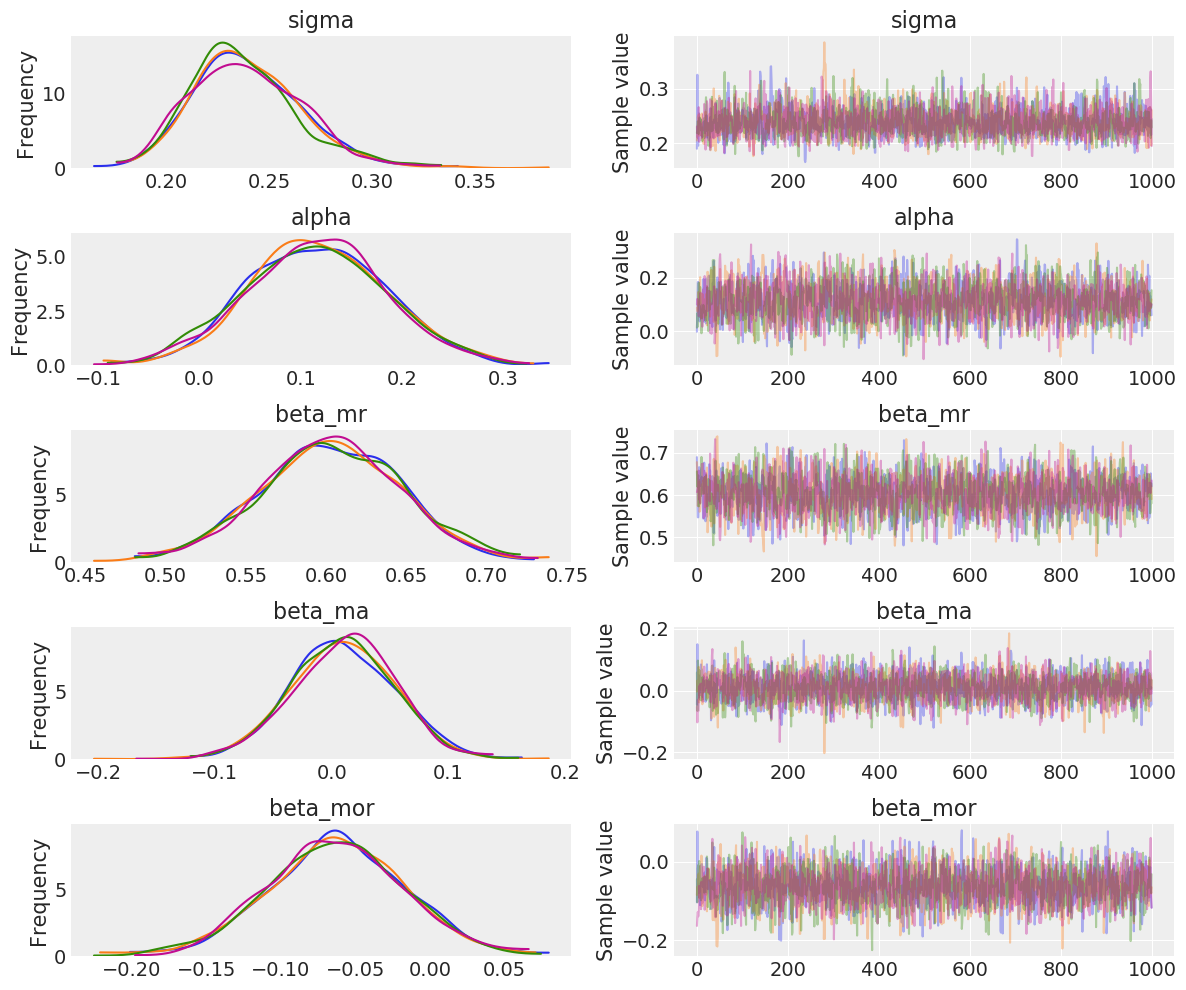

In [310]:
pm.traceplot(trace, varnames = ['sigma', 'alpha', 'beta_mr', 'beta_ma', 'beta_mor'])

In [314]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.115016,0.067884,0.001452,-0.023386,0.243341,2166.555217,0.999916
beta_mr,0.602641,0.043725,0.000914,0.518548,0.690092,2101.163562,0.999790
beta_ma,0.009303,0.043472,0.000840,-0.075593,0.091952,2839.309886,0.999805
beta_mor,-0.063466,0.045525,0.000862,-0.156596,0.023044,2703.240603,0.999879
sigma,0.238811,0.026285,0.000552,0.194226,0.294466,2613.441439,1.000307
mu__0,0.900052,0.051655,0.000959,0.799569,1.003176,3391.440870,1.000052
mu__1,1.798190,0.073596,0.001149,1.653464,1.938461,3743.590002,0.999672
mu__2,0.610926,0.076084,0.001467,0.459860,0.761309,2503.444800,0.999850
mu__3,1.135106,0.075615,0.001455,0.990279,1.282076,2976.434775,0.999987
mu__4,0.327345,0.072221,0.001502,0.191082,0.472891,2187.170823,0.999804


In [315]:
with pm.Model() as M53:
    sigma = pm.Uniform('sigma',0,5)
    alpha = pm.Normal('alpha',10,20)
    beta_mr = pm.Normal('beta_mr',0,10)
    beta_ma = pm.Normal('beta_ma',0,10)
    beta_mor = pm.Normal('beta_mor',0, 10)
    mu = pm.Deterministic('mu', alpha + beta_mr * df['Marriage'] + beta_ma * df['MedianAgeMarriage'] + beta_mor * df['mormon percentage SE'])
    divorce = pm.Normal('divorce', mu, sigma, observed = df['Divorce'])
    trace2 = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_mor, beta_ma, beta_mr, alpha, sigma]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 8000/8000 [00:30<00:00, 264.70draws/s]
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6831694968999495, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [316]:
pm.summary(trace2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,34.909274,7.139103,0.189343,21.168236,48.740677,1372.694074,1.000313
beta_mr,0.058932,0.087722,0.001954,-0.113406,0.223895,1735.434151,0.999640
beta_ma,-1.013732,0.237060,0.006230,-1.498052,-0.572389,1277.492675,1.000697
beta_mor,-0.612178,0.309951,0.006446,-1.215976,-0.004129,1793.094067,1.000736
sigma,1.469629,0.152816,0.003533,1.199180,1.783047,2053.739287,1.000213
mu__0,10.696562,0.319787,0.006834,10.088663,11.308081,1869.278036,1.000871
mu__1,10.160718,0.420024,0.008058,9.381344,11.020287,3019.904916,0.999925
mu__2,9.056411,0.479277,0.008994,8.075090,9.951554,2051.313437,1.000244
mu__3,11.915544,0.594545,0.011304,10.768174,13.113607,2219.755460,1.000849
mu__4,8.594075,0.337208,0.006668,7.948251,9.256681,2214.450244,1.000528


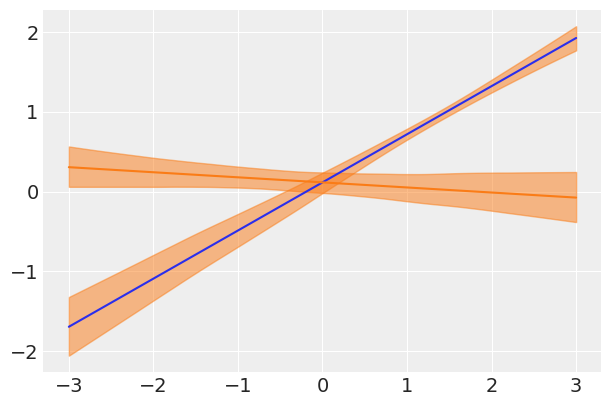

In [323]:
x_points = np.linspace(-3,3,100)
plt.plot(x_points, trace['alpha'].mean() + trace['beta_mr'].mean() * x_points)
plt.plot(x_points, trace['alpha'].mean()+ trace['beta_mor'].mean() * x_points)
mu_mr = trace['alpha'] + trace['beta_mr'] * x_points[:,None]
mu_mor = trace['alpha'] + trace['beta_mor'] * x_points[:,None]
az.plot_hpd(x_points, mu_mr.T)
az.plot_hpd(x_points, mu_mor.T)

### 5M5

To test the effect of price of gas on obesity, we could check the amount of calories eaten at restaurants and the calories burned through exercise in addition to the price of gas as predictors for obesity. If the effect of price of gas is captured by these two mechanisms, the effect of gas price in the counterfactual will be low.

### 5H1

In [325]:
df = pd.read_csv('../resources/Rethinking/Data/foxes.csv', sep = ';')

In [341]:
df.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [327]:
df[df.isna().any(axis=1)]

,group,avgfood,groupsize,area,weight


In [328]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 5 columns):
group        116 non-null int64
avgfood      116 non-null float64
groupsize    116 non-null int64
area         116 non-null float64
weight       116 non-null float64
dtypes: float64(3), int64(2)
memory usage: 4.6 KB


In [330]:
df['groupsize'].mean()

4.344827586206897

In [332]:
df['groupsize'].std()

1.5385111282516373

In [331]:
df['area'].mean()

3.1691379310344856

In [334]:
df['groupsize'].std()

1.5385111282516373

In [335]:
df['weight'].mean()

4.5296551724137935

In [336]:
df['weight'].std()

1.1840225695810702

In [337]:
with pm.Model() as H51_groupsize:
    sigma = pm.Uniform('sigma', 0,10)
    alpha = pm.Normal('alpha', 0,5)
    beta_g = pm.Normal('beta_g', 0,10)
    mu = pm.Deterministic('mu', alpha + beta_g * df['groupsize'])
    weight = pm.Normal('weight', mu, sigma, observed = df['weight'])
    trace_group = pm.sample(1000,tune= 1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_g, alpha, sigma]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:06<00:00, 1240.54draws/s]


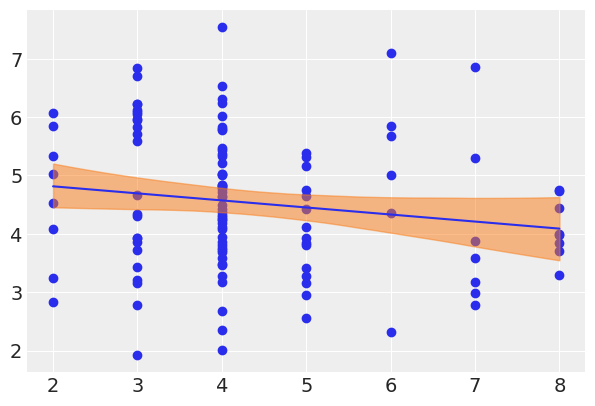

In [348]:
plt.scatter(df['groupsize'], df['weight'])
x_points = np.linspace(2,8,100)
plt.plot(x_points, trace_group['alpha'].mean()+ trace_group['beta_g'].mean()* x_points)
mu_pred = trace_group['alpha'] + trace_group['beta_g'] * x_points[:,None]
az.plot_hpd(x_points, mu_pred.T)

In [338]:
with pm.Model() as H51_area:
    sigma = pm.Uniform('sigma', 0,10)
    alpha = pm.Normal('alpha', 0,5)
    beta_a = pm.Normal('beta_a', 0,10)
    mu = pm.Deterministic('mu', alpha + beta_a * df['area'])
    weight = pm.Normal('weight', mu, sigma, observed = df['weight'])
    trace_area = pm.sample(1000,tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_a, alpha, sigma]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:07<00:00, 1116.46draws/s]


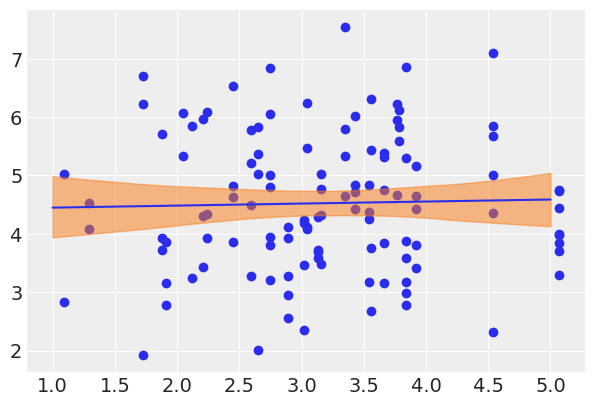

In [347]:
plt.scatter(df['area'], df['weight'])
x_points = np.linspace(1,5,100)
plt.plot(x_points, trace_area['alpha'].mean()+ trace_area['beta_a'].mean()* x_points)
mu_pred = trace_area['alpha'] + trace_area['beta_a'] * x_points[:,None]
az.plot_hpd(x_points, mu_pred.T)

It appears that individually, neither variable is a good predictor for weight

In [339]:
with pm.Model() as H51_both:
    sigma = pm.Uniform('sigma', 0,10)
    alpha = pm.Normal('alpha', 0,5)
    beta_a = pm.Normal('beta_a', 0,10)
    beta_g = pm.Normal('beta_g', 0,10)
    mu = pm.Deterministic('mu', alpha + beta_a * df['area'] + beta_g * df['groupsize'])
    weight = pm.Normal('weight', mu, sigma, observed = df['weight'])
    trace_both = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_g, beta_a, alpha, sigma]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 8000/8000 [00:09<00:00, 819.87draws/s]
The acceptance probability does not match the target. It is 0.8893209710880046, but should be close to 0.8. Try to increase the number of tuning steps.


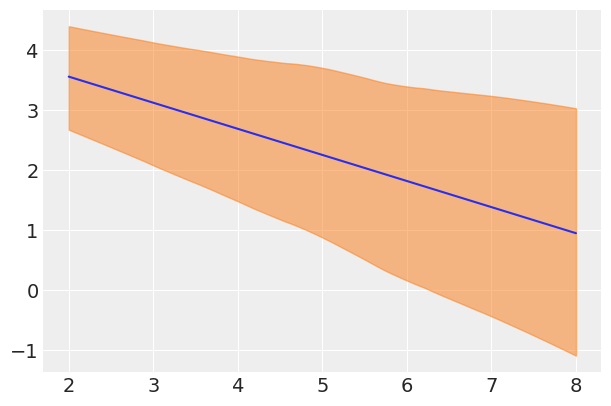

In [349]:
x_points = np.linspace(2,8,100)
plt.plot(x_points, trace_both['alpha'].mean()+ trace_both['beta_g'].mean()* x_points)
mu_pred = trace_both['alpha'] + trace_both['beta_g'] * x_points[:,None]
az.plot_hpd(x_points, mu_pred.T)

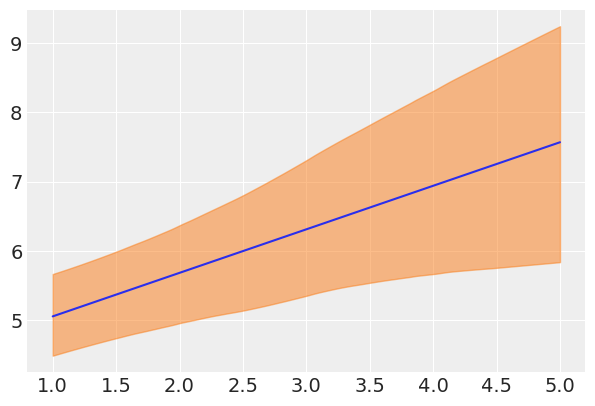

In [350]:
x_points = np.linspace(1,5,100)
plt.plot(x_points, trace_both['alpha'].mean()+ trace_both['beta_a'].mean()* x_points)
mu_pred = trace_both['alpha'] + trace_both['beta_a'] * x_points[:,None]
az.plot_hpd(x_points, mu_pred.T)

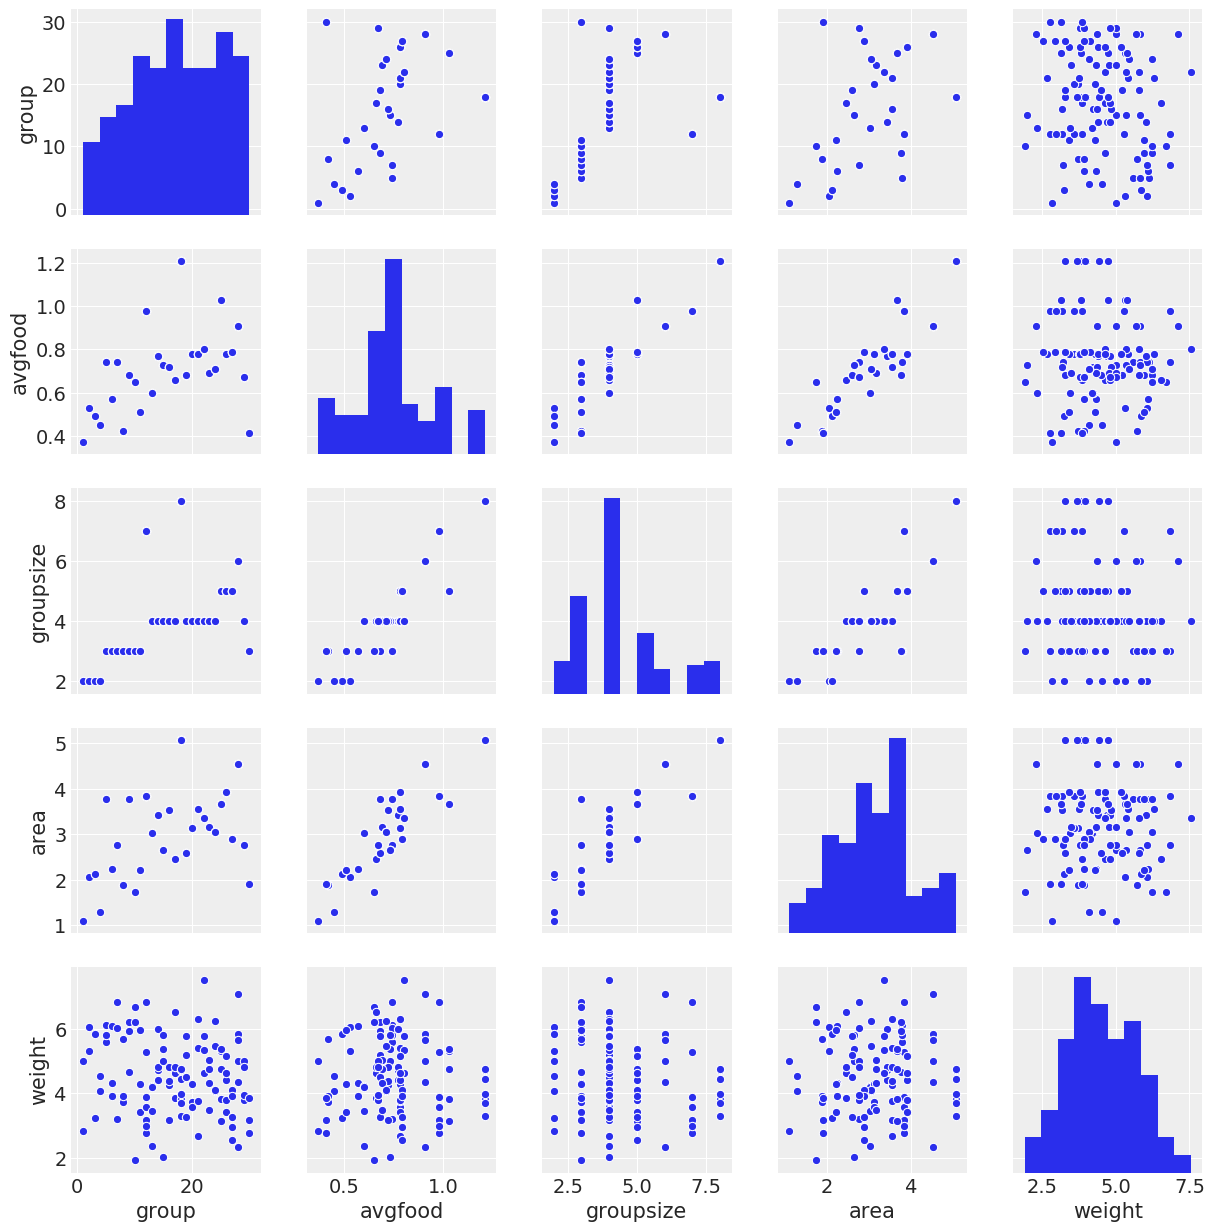

In [351]:
sns.pairplot(df)

Since area and groupsize are positively correlated, but have an opposite effet on weight, it appears in the individual regression as if neither is a good predictor. In the multiple regression, we can see the effect of each.